In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

In [18]:
tf.random.set_seed(41)
tfd = tfp.distributions
tfb = tfp.bijectors

In [44]:
p_mu = [0., 0.]
p_L = tfb.Chain([tfb.TransformDiagonal(tfb.Softplus()),
                tfb.FillTriangular()])(tf.random.uniform([3]))
p = tfd.MultivariateNormalTriL(loc = p_mu, scale_tril = p_L)
p

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

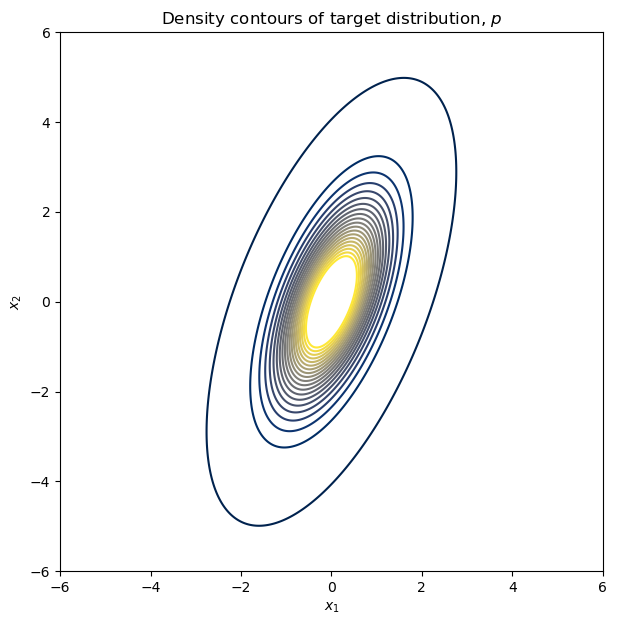

In [22]:
# Plot the target distribution's density contours

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
f, ax = plt.subplots(1, 1, figsize=(7, 7))

# Density contours are linearly spaced
contour_levels = np.linspace(1e-4, 10**(-0.8), 20) # specific to this seed
ax = plot_density_contours(p.prob, X1, X2, 
                           {'levels':contour_levels, 
                            'cmap':'cividis'}, ax=ax)
ax.set_xlim(-6, 6); ax.set_ylim(-6, 6); 
ax.set_title('Density contours of target distribution, $p$')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$');

In [30]:
tf.random.set_seed(41)

q = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.random.normal([2])), 
                              scale_diag = tfp.util.TransformedVariable(tf.random.uniform([2]), bijector = tfb.Exp()))

In [33]:
q.trainable_variables

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([-0.9192473 , -0.53105015], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([-0.51546943, -0.3044765 ], dtype=float32)>)

In [47]:
@tf.function

def loss_and_grads(dist_a, dist_b, reverse = False):
    with tf.GradientTape() as tape:
        if not reverse:
            loss = tfd.kl_divergence(dist_a,dist_b)
            
        else:
            loss = tfd.kl_divergence(dist_b, dist_a)
    return loss, tape.gradient(loss, dist_a.trainable_variables)

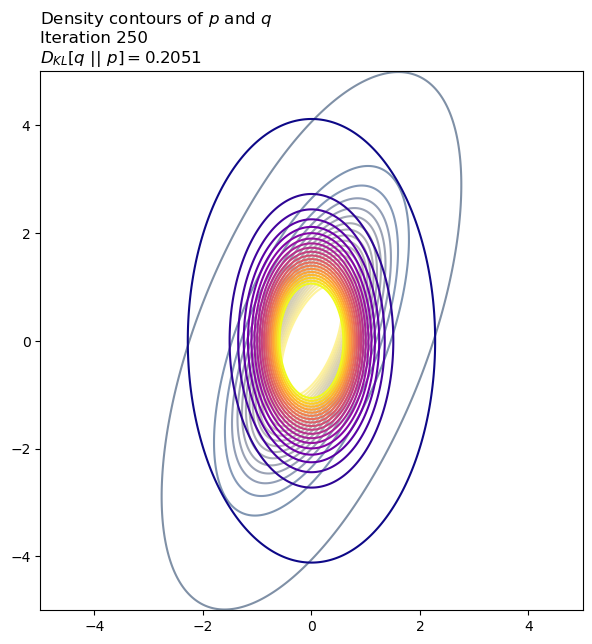

In [38]:

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

Variance is underestimated as expected.

Lets try KL[p||q]

In [48]:
tf.random.set_seed(41)

q_rev = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.random.normal([2])), 
                              scale_diag = tfp.util.TransformedVariable(tf.random.uniform([2]), bijector = tfb.Exp()))

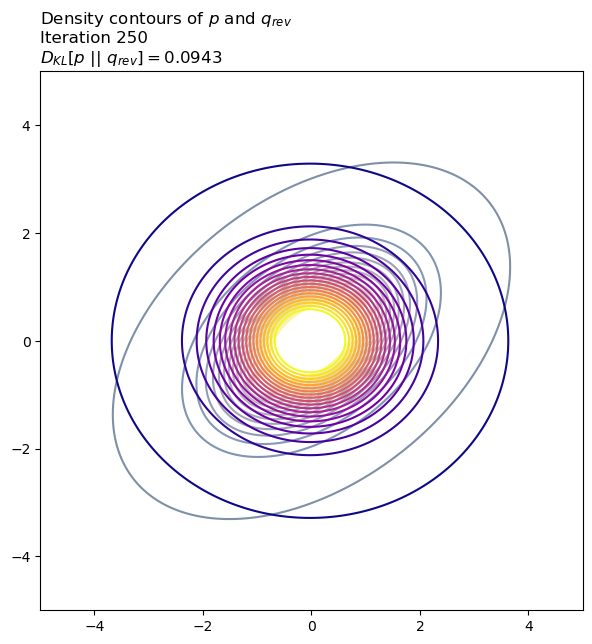

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    # Reverse the KL divergence terms - compute KL[p || q_rev] 
    q_rev_loss, grads = loss_and_grads(q_rev, p, reverse=True)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q_rev.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q_rev.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q_{rev}$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[p \ || \ q_{rev}] = ' + 
                      str(np.round(q_rev_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

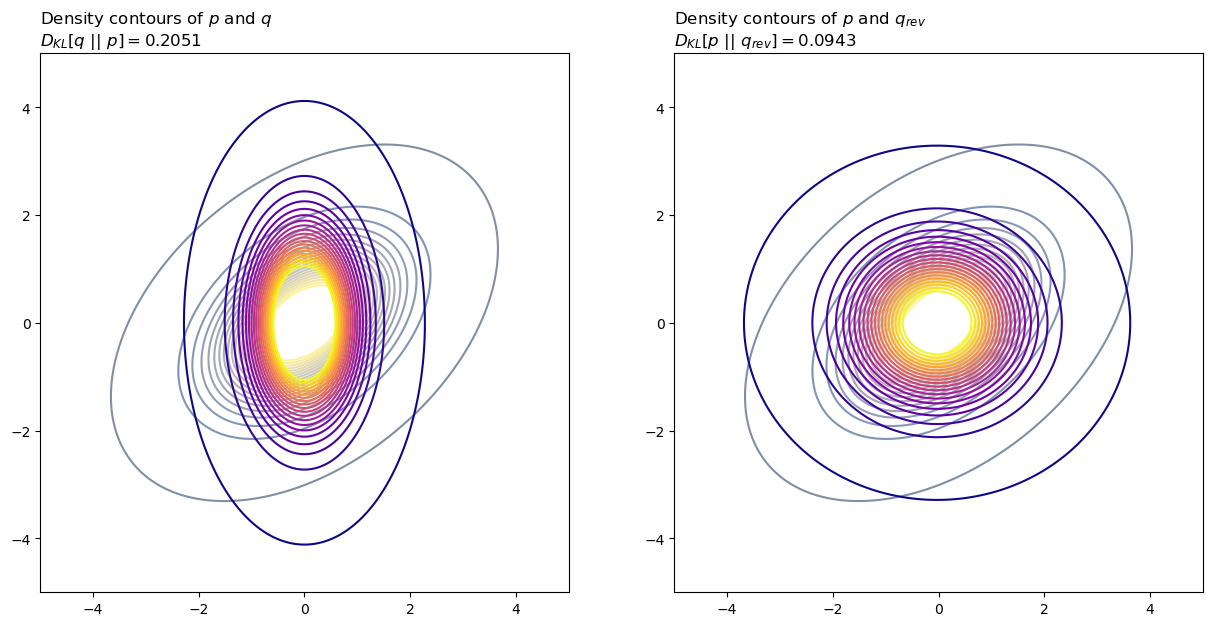

In [50]:
# Plot q and q_rev alongside one another

f, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[0])
axs[0] = plot_density_contours(q.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[0])
axs[0].set_title('Density contours of $p$ and $q$\n' +
              '$D_{KL}[q \ || \ p] = ' + str(np.round(q_loss.numpy(), 4)) + '$',
              loc='left')

axs[1] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[1])
axs[1] = plot_density_contours(q_rev.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[1])
axs[1].set_title('Density contours of $p$ and $q_{rev}$\n' +
              '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(q_rev_loss.numpy(), 4)) + '$',
              loc='left');

Full Gaussian as posterior

In [53]:
# Define the approximating distribution

scale_tril_init = tfb.FillScaleTriL()(tf.random.normal([3]))
q = tfd.MultivariateNormalTriL(loc=tf.Variable(tf.random.normal([2])),
                               scale_tril=tfp.util.TransformedVariable(scale_tril_init,
                                                                       bijector=tfb.FillScaleTriL()))

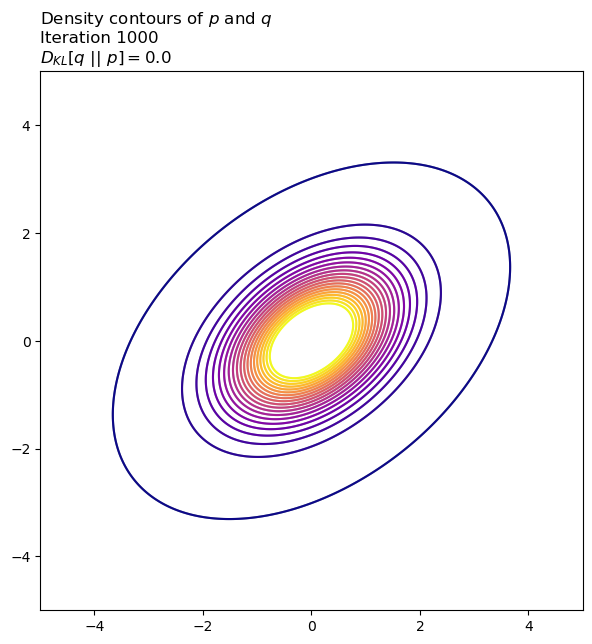

In [55]:
num_train_steps = 1000
opt = tf.keras.optimizers.Adam(learning_rate=.01)
reverse = False 
for i in range(num_train_steps):
   
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)